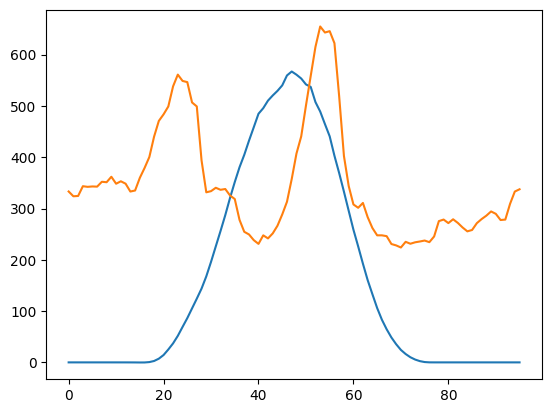

In [156]:
import scipy.optimize as opt
import matplotlib.pyplot as plt
import csv
import sys
sys.path.insert(0,"../")
import numpy as np
from scipy.optimize import Bounds
from scipy.optimize import NonlinearConstraint
from scipy.sparse import csc_matrix
import cvxpy as cp
import math

data = {
    'load':[],
    'solar':[],
    'cost':[]
}

with open('../ElectricityAndSolar/generated_data/15_minute_averages.csv',newline='') as csvfile:
    data_read = csv.reader(csvfile,delimiter=',',quotechar='|')
    #print(data[0])
    for row in data_read:
        #print(row[0])
        data['solar'].append(eval(row[1]))
        data['load'].append(eval(row[0]))
        data['cost'].append(eval(row[2]))



#from scipy.optimize import LinearConstraint
data['solar'] = data['solar'][80:] + data['solar'][:80]
plt.plot(data['solar'])
plt.plot(data['load'])
plt.show()

Demand response event happens from 3 to 7 PM

In [157]:
storage_capacity = 5000
storage_power = 5000/4
soc0 = 0.4
soc = [soc0*storage_capacity]
B = []

dr_times = [1 if i > 60 and i < 76 else 0 for i in range(96)]
export_allowed = True
for i in range(96):
    if(dr_times[i]):
        battery = min(storage_power,storage_capacity/2)
    else:
        battery = -min(storage_power,storage_capacity/22)
    #print("est",battery)
    
    if (battery > 0 and not export_allowed):
        battery = min(battery, data['load'][i]*4)
    soc_next = soc[i] - battery/4
    #print("soc_next",soc_next)
    if(soc_next > storage_capacity):
        battery = -(storage_capacity - soc[i])*4
        #print(battery)
    elif(soc_next <= 0):
        battery = soc[i] * 4
    #print(battery)
    B.append(battery)
    soc.append(soc[i]-battery/4)
hrs = [i/4 for i in range(96)]

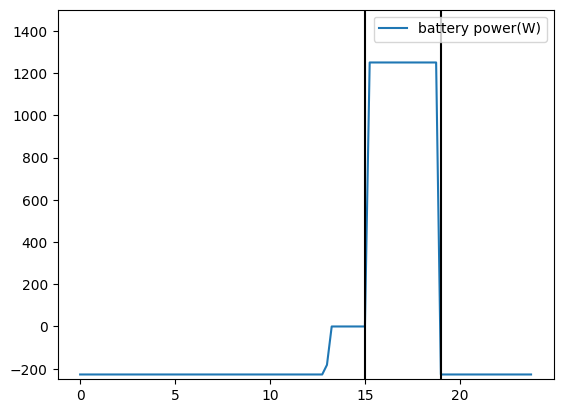

In [158]:
plt.plot(hrs,B,label='battery power(W)')
plt.vlines(x = 15, ymin = -300, ymax = 1500,
           colors = 'black')
plt.vlines(x = 19, ymin = -300, ymax = 1500,
           colors = 'black')
plt.ylim(-250,1500)
plt.legend()

demand based peak reduction

In [159]:
threshold = 2000
B=[]
storage_capacity = 5000
storage_power = 5000/4
soc0 = 0.4
soc = [soc0*storage_capacity]
B = []
def delta_func(x):
    if(x>0):
        return 1
    else:
        return -1
    

for i in range(96):

    battery = min(storage_power,abs(data['load'][i]*4-threshold))*delta_func(data['load'][i]*4 - threshold)
    #print(battery)
    if (battery > 0 and not export_allowed):
        battery = min(battery, data['load'][i]*4)
    soc_next = soc[i] - battery/4
    #print("soc_next",soc_next)
    if(soc_next > storage_capacity):
        battery = -(storage_capacity - soc[i])*4
        #print(battery)
    elif(soc_next <= 0):
        battery = soc[i] * 4
    #print(battery)
    B.append(battery)
    soc.append(soc[i]-battery/4)
        

3.9347081830400006


Text(0.5, 0, 'time of day (hrs)')

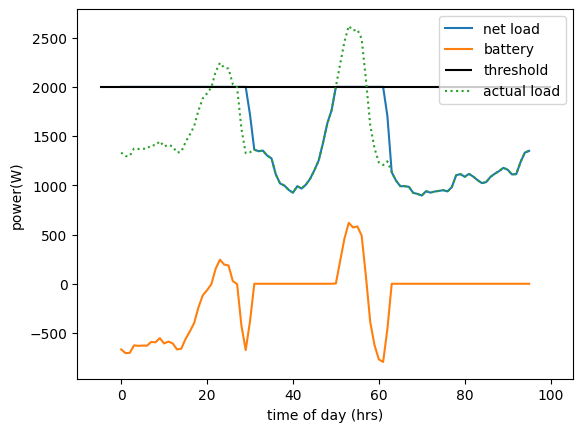

In [160]:
net_load = [data['load'][i] - B[i]/4 for i in range(96)]
plt.plot([x*4 for x in net_load],label='net load')
plt.plot(B,label='battery')
plt.hlines(y = threshold, xmin = -5, xmax = 100,
           colors = 'black',
           label='threshold')
plt.plot([x*4 for x in data['load']],linestyle='dotted',label='actual load')

print(sum([abs(x) for x in B])/storage_capacity)
plt.legend()
plt.ylabel("power(W)")
plt.xlabel("time of day (hrs)")